# Questão 02

- Respostas da 2º Avaliação de SD - 2023 
- Aluno: Matheus Victor Ferreira da Silva
- Explique e demonstre com Python a vantagem de se usar Threads em Python para aplicações IO-Block mesmo que em Python as Threads não sejam executadas ao mesmo tempo. Para essa demonstração não use o caso do download visto em sala de aula, elabore outro exemplo

## Bibliotecas

In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
from threading import Thread
from time import sleep, time
import seaborn as sns
import matplotlib.pyplot as plt

## Conect The Stars

O jogo "[Connect The Stars](https://connectthestars.xyz/)" tem como objetivo descobrir como duas estrelas de cinema estão conectadas através de seus filmes. Primeiramente é definido dois atores, que são considerados como pontos de início e fim. Um exemplo é demonstrado na imagem abaixo, onde é apresentado uma sequência que interlga o ator "Brad Pitt" ao ator brasileiro "Seu Jorge":

![Exemplo](exmp.png)

Brad Pitt trabalhou em "O Curioso Caso de Benjamin Button (2008)", onde Cate Blanchett também trabalhou. Além disso, Blanchett atuou em "A Vida Marinha com Steve Zissou (2004)" com Seu Jorge. Com isso, temos a sequência que interliga os dois atores.

## Implementação

Este programa tem como objetivo encontrar a sequências possíveis que interliguem a atriz "[Fernanda Montenegro](https://www.themoviedb.org/person/10055-fernanda-montenegro?language=pt-BR)" à atriz "[Meryl Streep](https://www.themoviedb.org/person/5064-meryl-streep?language=pt-BR)". Para isso, foi utilizado o mecanismo de Web Scraping para obter os dados necessários sobre filmes e atores, o mecanismo busca dados a partir das páginas HTML do site [TMDb](https://www.themoviedb.org/) que são obtidas a partir de requisições feitas pelo o próprio programa.

Na página de cada ator está listado os principais filmes que aquele ator trabalhou. É a partir destes filmes listados que é iniciado cada thread, por meio da raspagem de dados inicial são obtidos os 8 filmes principais da atriz inicial, que é "Fernanda Montenegro". Para cada filme será iniciado uma Thread, que irá executar a função de buscar a sequência entre as atrizes, buscando o elenco principal do filme e em seguida escolhendo um ator/atriz que não esteja no histórico de já vistos. Em seguida o processo é repetido, até o número de itens do histórico ser maior que 100 ou se for encontrado a sequência.

O uso de Threads no processamento concorrente é importante neste caso pois possibilita que enquanto uma Thread esteja realizando a requisição da página HTML, outras Threads podem continuar suas devidas buscas. Outro ponto importante, além da espera da requisição foi necessário implementar um mecanismo de espera no caso de sobrecarga de requisições, pois o site [TMDb](https://www.themoviedb.org/) limita o número de requisições por segundo em 50. Logo, quando uma requisição retorna com status 429 (*Too Many Requests*) a Thread é pausada por 5 segundos antes de tentar novamente.

![Limite de Requisições](./limite.png)

In [2]:

# Informações importantes
tmdb = "https://www.themoviedb.org"
h = {'User-Agent': "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36"}

### Classe Item

A classe Item foi criada para melhorar a organização das informações do filme ou ator. Além disso, para facilitar, ao ser instanciado passando apenas a url, o objeto já faz automáticamente a raspagem daquela página.

In [3]:
class Item:
    # Ao ser instanciado passando apenas a url, o objeto já faz automáticamente a raspagem daquela página.
    def __init__(self, url=None, tipo='filme', id=None, name=None, html=None, download=True, thr=None):
        self.tipo = tipo
        if url != None and download:
            aux = url.replace(tmdb, '')
            self.id = int(aux.split('/')[-1]) if tipo == 'filme' else int(aux.split('/')[2].split('-')[0])
            self.thr = thr
            code = 0
            while code != 200:
                r = requests.get(url, headers=h, timeout=5)
                code = r.status_code
                if code == 404:
                    # print(f"status: {code} | {url} | T{thr}")
                    url = tmdb + '/tv/' + str(self.id)
                    # print('Novo url: ', url, f'| T{thr}')
                elif code == 429:
                    # print(f"status: {code} | {url} | T{thr}")
                    sleep(5)
            self.url = url
            self.html = bs(r.text, 'html.parser')
            self.name = self.html.find('div', {'class': 'title'}).find('a').text if tipo == 'filme' else self.html.find('h2', {'class': 'title'}).text
        else:
            self.id = id
            self.name = name
            self.html = html
            self.url = url
    
    def pegaId(self):
        return self.link.split('/')[-2] if self.tipo == 'filme' else self.link.split('/')[2].split('-')[0]
    
    def __str__(self):
        return f'{self.id} - {self.name} - {self.url} - {self.tipo} - html = {"TEM" if self.html != None else "Nao tem"}'


#### Classe Filme

O filme herda atributos e métodos de Item, além disso deve possuir uma lista com seus principais atores, que virá no HTML.

In [4]:
class Filme(Item):

    def __init__(self, url, thr=None):
        super().__init__(url=url, tipo='filme', thr=thr)
        aux = [(ator.find('a')['href'].split('/')[-1].split('-')[0], ator.find('p').text) 
               for ator in self.html.find_all('ol', {'class': 'people scroller'})[0].find_all('li')][:-1]
        self.elenco = [
            Item(
                id=int(x[0]),
                name=x[1], 
                tipo='ator', 
                url=f'{tmdb}/person/{x[0]}', 
                download=False)
            for x in aux]

#### Classe Ator

O Ator herda atributos e métodos de Item, além disso deve possuir uma lista com seus principais filmes, que virá no HTML.

In [5]:
class Ator(Item):
    def __init__(self, url,  thr=None):
        super().__init__(url=url, tipo='ator',  thr=thr)
        ids = [ (
                    int(filme.find('a')['href'].split('/')[-1]),
                    filme.find('p').text
                ) for filme in self.html.find_all('div', id='known_for')[0].find_all('li')]
        self.know = [ 
            Item(
                id=i[0],
                name=i[1], 
                tipo='filme', 
                url=f"{tmdb}/movie/{i[0]}", 
                download=False) for i in ids
            ]

### Busca Sequência

In [6]:
# Função simples que tem objetivo de buscar um item pelo o id em uma lista.
def busca(item, lista):
    r = [x for x in lista if x.id == item.id]
    return len(r) > 0, r[0] if len(r) > 0 else None

#### Escolhas

Quando as informações de um filme é retornado e extraído, é necessário escolher o próximo ator que fará parte da sequência. Para isso, é verificado se o ator já está no histórico de já vistos, caso não esteja, a escolha é feita. Caso o ator já esteja no histórico, é escolhido o próximo ator que não esteja no histórico. Caso não haja mais atores para serem escolhidos, a Thread é finalizada. A mesma operação é feita para a escolha do próximo filme.

In [7]:
def escolheAtor(atual:Filme, historico:list):
    escolhido = None
    i = 0
    while escolhido == None and i < len(atual.elenco):
        if busca(item=atual.elenco[i], lista=historico)[0] == False:
            escolhido = atual.elenco[i]
        i += 1
    return escolhido

In [8]:
def escolheFilme(atorAtual:Ator, historico:list):
    escolhido = None
    i = 0
    while escolhido == None and i < len(atorAtual.know):
        if busca(item=atorAtual.know[i], lista=historico)[0] == False:
            escolhido = atorAtual.know[i]
        i += 1
    return escolhido

#### Busca Sequência

A variável possível determina se ainda há a possibilidade de encontrar a sequência obtendo apenas filmes principais ou os atores principais, dos filmes presentes. Como este programa não procura filmes que não estão na lista de filmes principais, é possível que a sequência não seja encontrada, mesmo que exista.

In [9]:
def buscaSeq(movInit:Item, s2:Ator, seq:dict, thr:int, numMax:int=100, possivel:bool=True):
    tempoBusca = time()
    while len(seq['historico']) < numMax and seq['encontrou'] == False and possivel:
        seq['historico'].append(Filme(url=movInit.url, thr=thr)) # Requisitar o filme e já colocar no historico.
        encontrou, ator = busca(item=s2, lista=seq['historico'][-1].elenco)

        # Encontrou?
        if encontrou: # Sim:
            seq['historico'].append(s2)
            seq['encontrou'] = True

        else: # Não:

            # Escolher o ator entre o elenco, deve ser alguém que não esteja no historico.
            atorAtual = escolheAtor(atual=seq['historico'][-1], historico=seq['historico'])

            if atorAtual != None: # Ainda é possivel encontrar o caminho.
                seq['historico'].append(Ator(url=atorAtual.url, thr=thr))
                movInit = escolheFilme(atorAtual=seq['historico'][-1], historico=seq['historico'])
            else:
                possivel = False
    tempoFinalBusca = time() - tempoBusca
    print(f"Seq: {thr} | FIM DA BUSCA | {'ENCONTRADO' if seq['encontrou'] else 'NAO ENCONTRADO'} | t: {tempoFinalBusca}s")

#### Conecta

A função conecta tem o objetivo de criar as Threads determinando que elas a executarem a função `buscaSeq` e em seguida iniciar a Thread.

In [10]:
def conecta(s1, s2, qntThrs=1):
    numMax = 100
    sequencias = [{'encontrou': False, 'historico': [s1]} for _ in range(qntThrs)]

    encontrados = 0
    thrs = [Thread(target=buscaSeq, args=(s1.know[i], s2, sequencias[i], i, numMax)) for i in range(qntThrs)]

    t = time()

    for thr in thrs:
        thr.start()

    for thr in thrs:
        thr.join()
    
    final = time() - t

    for seq in sequencias:
        if seq['encontrou']:
            encontrados += 1

    return sequencias, encontrados, final

#### Função conectaSemThread

A função conectaSemThread tem o objetivo de executar a função `buscaSeq` sem a utilização de Threads, para que seja possível comparar o tempo de execução com e sem Threads.

In [11]:
def conectaSemThread(s1, s2, qnt=1):
    numMax = 100
    sequencias = [{'encontrou': False, 'historico': [s1]} for _ in range(qnt)]
    encontrados = 0

    t = time()
    
    for index, seq in enumerate(sequencias):
        buscaSeq(movInit=s1.know[index], s2=s2, seq=seq, thr=index, numMax=numMax)
    
    final = time() - t

    for seq in sequencias:
        if seq['encontrou']:
            encontrados += 1

    return sequencias, encontrados, final

## Teste

In [12]:
urlS1 = "https://www.themoviedb.org/person/10055-fernanda-montenegro"
urlS2 = "https://www.themoviedb.org/person/5064-meryl-streep"

Criação dos objetos, ao ser executado o construtor já faz a raspagem da página HTML da página das duas artistas.

In [13]:
s1, s2 = Ator(url=urlS1), Ator(url=urlS2)

### Teste com Threads

In [14]:
seqs1, encontrados1, tempo1 = conecta(s1, s2, qntThrs=8)

Seq: 3 | FIM DA BUSCA | NAO ENCONTRADO | t: 8.211337327957153s
Seq: 0 | FIM DA BUSCA | NAO ENCONTRADO | t: 9.092081308364868s
Seq: 5 | FIM DA BUSCA | NAO ENCONTRADO | t: 11.919637203216553s
Seq: 7 | FIM DA BUSCA | NAO ENCONTRADO | t: 13.055224180221558s
Seq: 6 | FIM DA BUSCA | ENCONTRADO | t: 30.330496788024902s
Seq: 2 | FIM DA BUSCA | ENCONTRADO | t: 41.53800058364868s
Seq: 4 | FIM DA BUSCA | NAO ENCONTRADO | t: 46.918702602386475s
Seq: 1 | FIM DA BUSCA | NAO ENCONTRADO | t: 67.10902762413025s


In [15]:
print(f'Qnt de Sequencias encontradas: {encontrados1}')
print(f'Tempo de execução: {tempo1}s')

Qnt de Sequencias encontradas: 2
Tempo de execução: 67.11134362220764s


### Teste sem Threads

In [16]:
seqs2, encontrados2, tempo2 = conectaSemThread(s1, s2, 8)

Seq: 0 | FIM DA BUSCA | NAO ENCONTRADO | t: 7.457204580307007s
Seq: 1 | FIM DA BUSCA | NAO ENCONTRADO | t: 50.003766775131226s
Seq: 2 | FIM DA BUSCA | ENCONTRADO | t: 27.126829624176025s
Seq: 3 | FIM DA BUSCA | NAO ENCONTRADO | t: 6.308543682098389s
Seq: 4 | FIM DA BUSCA | NAO ENCONTRADO | t: 34.5151469707489s
Seq: 5 | FIM DA BUSCA | NAO ENCONTRADO | t: 10.331662893295288s
Seq: 6 | FIM DA BUSCA | ENCONTRADO | t: 17.46849489212036s
Seq: 7 | FIM DA BUSCA | NAO ENCONTRADO | t: 10.700839281082153s


In [17]:
print(f'Qnt de Sequencias encontradas: {encontrados2}')
print(f'Tempo de execução: {tempo2}s')

Qnt de Sequencias encontradas: 2
Tempo de execução: 163.9130470752716s


### Comparação dos Resultados

In [18]:
f"Houve um ganho de {round(tempo2 - tempo1, 4)} segundos com o uso de threads."

'Houve um ganho de 96.8017 segundos com o uso de threads.'

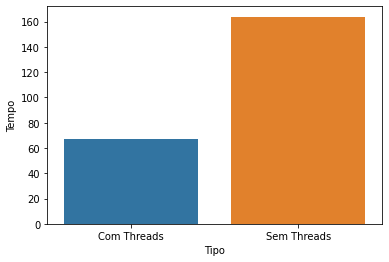

In [19]:
df = pd.DataFrame({'Tempo': [tempo1, tempo2],'Tipo': ['Com Threads', 'Sem Threads']})
sns.barplot(x='Tipo', y='Tempo', data=df)
plt.show()

Com isso, percebe-se que a operação obteve um ganho de desempenho utilizando Threads.

### Apresentação de Sequências

In [64]:
def showSeq(seq):
    print(f"{'-'*50}")
    print(f"A atriz {seq['historico'][0].name} atuou em: ", end='')
    for i in seq['historico'][1:-1]:
        if i.tipo == 'filme':
            print(f"{i.name}")
        else:
            print(f"onde o ator {i.name} tbm trabalhou.\nAlém disso, {i.name.split(' ')[0]} atuou em: ", end='')
    print(f"Que por fim, {seq['historico'][-1].name} trabalhou!")


In [66]:
showSeq(seqs1[2])

--------------------------------------------------
A atriz Fernanda Montenegro atuou em: A Dog's Will
onde o ator Matheus Nachtergaele tbm trabalhou.
Além disso, Matheus atuou em: City of God
onde o ator Alexandre Rodrigues tbm trabalhou.
Além disso, Alexandre atuou em: City of God: 10 Years Later
onde o ator Alice Braga tbm trabalhou.
Além disso, Alice atuou em: I Am Legend
onde o ator Will Smith tbm trabalhou.
Além disso, Will atuou em: Suicide Squad
onde o ator Jared Leto tbm trabalhou.
Além disso, Jared atuou em: Mr. Nobody
onde o ator Sarah Polley tbm trabalhou.
Além disso, Sarah atuou em: Dawn of the Dead
onde o ator Ving Rhames tbm trabalhou.
Além disso, Ving atuou em: Pulp Fiction
onde o ator John Travolta tbm trabalhou.
Além disso, John atuou em: Grease
onde o ator Olivia Newton-John tbm trabalhou.
Além disso, Olivia atuou em: Xanadu
onde o ator Gene Kelly tbm trabalhou.
Além disso, Gene atuou em: Singin' in the Rain
onde o ator Donald O'Connor tbm trabalhou.
Além disso, Donal